# BOW Logistic Regression for Amazon Review Classification

In [1]:
from datasets import load_dataset
dataset = load_dataset(
    'amazon_us_reviews', 'Mobile_Electronics_v1_00')

Reusing dataset amazon_us_reviews (/Users/elinottonson/.cache/huggingface/datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)
100%|██████████| 1/1 [00:00<00:00, 81.28it/s]


In [2]:
import pandas as pd
data = dataset['train'][:]
df = pd.DataFrame(data, columns=data.keys())
training_data_unbalanced = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(training_data_unbalanced.index)
print(f"No. of training examples: {training_data_unbalanced.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}") 


No. of training examples: 83980
No. of testing examples: 20995


In [3]:

training_1 = training_data_unbalanced[training_data_unbalanced['star_rating'] == 1].sample(n=2000,random_state=42)
training_2 = training_data_unbalanced[training_data_unbalanced['star_rating'] == 2].sample(n=2000,random_state=42)
training_3 = training_data_unbalanced[training_data_unbalanced['star_rating'] == 3].sample(n=2000,random_state=42)
training_4 = training_data_unbalanced[training_data_unbalanced['star_rating'] == 4].sample(n=2000,random_state=42)
training_5 = training_data_unbalanced[training_data_unbalanced['star_rating'] == 5].sample(n=2000,random_state=42)


<class 'pandas.core.frame.DataFrame'>


In [4]:

training_data = pd.concat([training_1, training_2, training_3, training_4, training_5])

## Hyperparameter Tuning
We perform hyperparameter tuning on a small sample of the dataset for performance reasons, we will then train the model with the best hyperparameters.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import *
from nltk.tokenize import NLTKWordTokenizer
import numpy as np

X_train_tune = training_data['review_body']
y_train_tune = training_data['star_rating']
X_test_tune = testing_data['review_body']
y_test_tune = testing_data['star_rating']

tknzr = NLTKWordTokenizer()
v = TfidfVectorizer(tokenizer=tknzr.tokenize)
X_train_tune = v.fit_transform(X_train_tune)
X_test_tune = v.transform(X_test_tune)

print(X_train_tune.shape)
print(X_test_tune.shape)

(10000, 25607)
(20995, 25607)


### Cross Validation Hyperparameter Tuning
We performed hyperparameter tuning on C (the regularization strength). Since we have a multiclass classifier, we were limited to using the 'newton-cg' solver (Could maybe go into more detail about the newton-cg solver to fill some space), and l2 regularization.

Our model failed to converge with ‘lbfgs’, ‘sag’, and ‘saga’ solvers (We could maybe also go more in depth with these to fill more space.)

We are training and evaluating each model using cross validation for each value of C, and we're using per-class f1_scores as our evaluation of performance for each value of C.

In [21]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

def run_classifier(C, splits=5):
    cv = KFold(n_splits=splits, shuffle=True, random_state=12345)
    scores = np.zeros(shape=(splits, 5)) # Shape is number of folds by number of classes.
    i = 0
    for train_index, test_index in cv.split(X_train_tune):
        X_tr, X_ts = X_train_tune[train_index], X_train_tune[test_index]
        y_tr, y_ts = y_train_tune.iloc[train_index], y_train_tune.iloc[test_index]
        LR = LogisticRegression(solver='newton-cg', C=C, n_jobs=-1)
        LR.fit(X_tr, y_tr)
        pr = LR.predict(X_ts)
        scores[i] = f1_score(y_ts, pr, average=None) # Calculate f1 score for each class.
        i += 1
    return scores.mean(0) # Means of f1 score for each class.

params = {
    "solver": ['newton-cg'],
    "penalty": ['l2'],
    "C": [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
}

scores = np.zeros(shape=(len(params['C']), 5))
i = 0
for c in params['C']:
    scores[i] = run_classifier(c)
    i += 1

scores = scores.T # We want rows to represent each class.

### Hyperparameter Plotting
Below is a plot of the per-class f1 scores with respect to the regularization weight (C).

It is evident that classes 2, 3, and 4 which correspond to 2, 3, and 4 star ratings, have a much lower f1 score for classification. This is likely because there is a much smaller population of 2, 3, and 4 star ratings in our dataset than 1 and 5 star ratings. We will need to consider ways to address this uneven class distribution.

Best C: 1


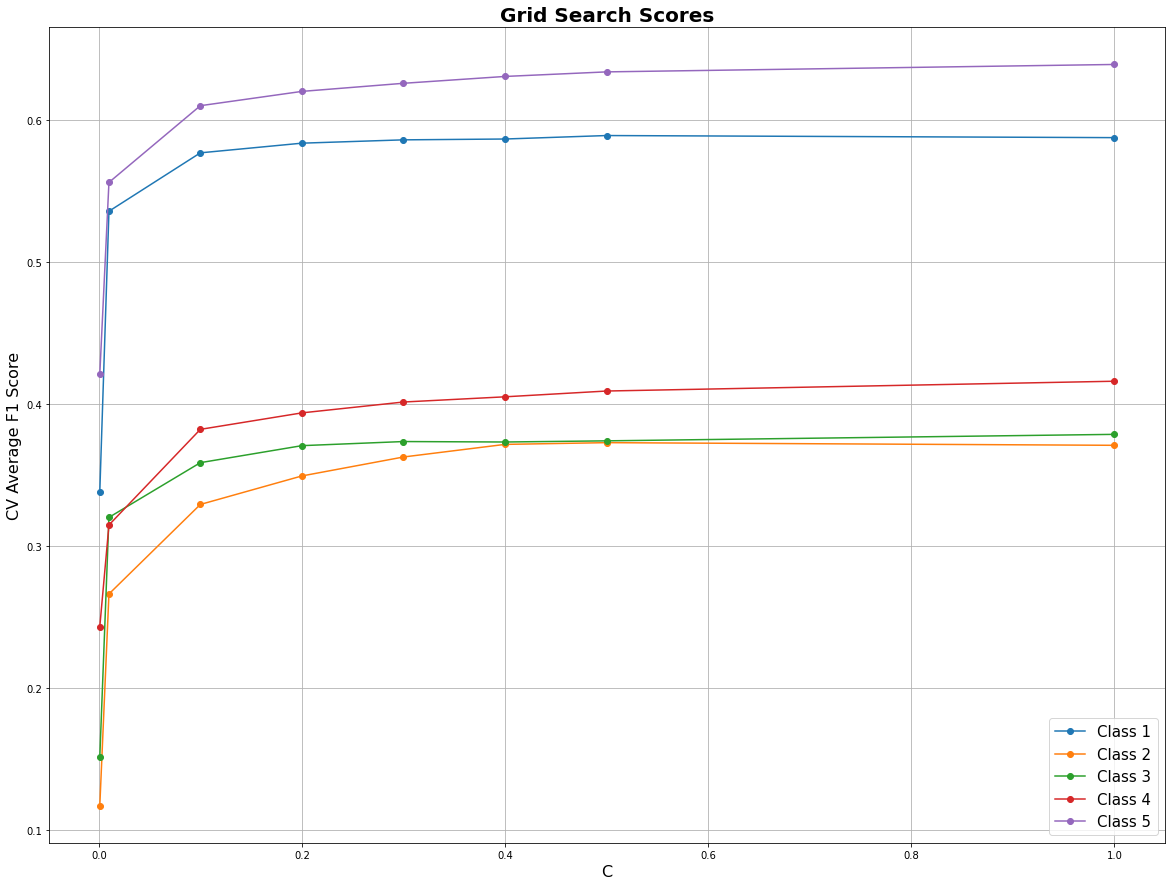

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

best_c = params['C'][np.argmax(scores.mean(0))]

_, ax = plt.subplots(1,1)
for i in range(len(scores)):
    ax.plot(params['C'], scores[i], '-o', label=f"Class {i + 1}")
ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel("C", fontsize=16)
ax.set_ylabel('CV Average F1 Score', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')

print(f"Best C: {best_c}")

## Final Model Training
We are now training the model on the full dataset using the best value we found for C during hyperparameter tuning.

In [23]:
X_train = training_data['review_body']
y_train = training_data['star_rating']
X_test = testing_data['review_body']
y_test = testing_data['star_rating']

tknzr = NLTKWordTokenizer()
v = TfidfVectorizer(tokenizer=tknzr.tokenize)
X_train = v.fit_transform(X_train)
X_test = v.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(10000, 25607)
(20995, 25607)


In [24]:
model = LogisticRegression(solver='newton-cg', C=best_c, class_weight='balanced', n_jobs=-1)
fitted_model = model.fit(X_train, y_train)
prediction = fitted_model.predict(X_test)
probs = fitted_model.predict_proba(X_test)

### Model Results

Logistic regression doesn't seem to provide us with the best results for this dataset. We have okay predictions for classes 1 and 5, but otherwise our model is failing to correctly classify classes 2-4.

Additionally, the bag of words approach likely provides too small of a feature space to accurately predict customer reviews. We will begin to investigate more complex tokenization, and feature extraction approaches such as dependency relations, word embeddings, etc.

For this experiment we only considered the content of the reviews while our dataset offers many more useful fields we can consider such as the review title, number of helpful votes, and number of total votes.

              precision    recall  f1-score   support

           1       0.64      0.61      0.63      3540
           2       0.21      0.34      0.26      1479
           3       0.26      0.37      0.30      1988
           4       0.34      0.38      0.36      3673
           5       0.83      0.66      0.73     10315

    accuracy                           0.55     20995
   macro avg       0.46      0.47      0.46     20995
weighted avg       0.62      0.55      0.58     20995

AUC Score: 0.7971548317570205


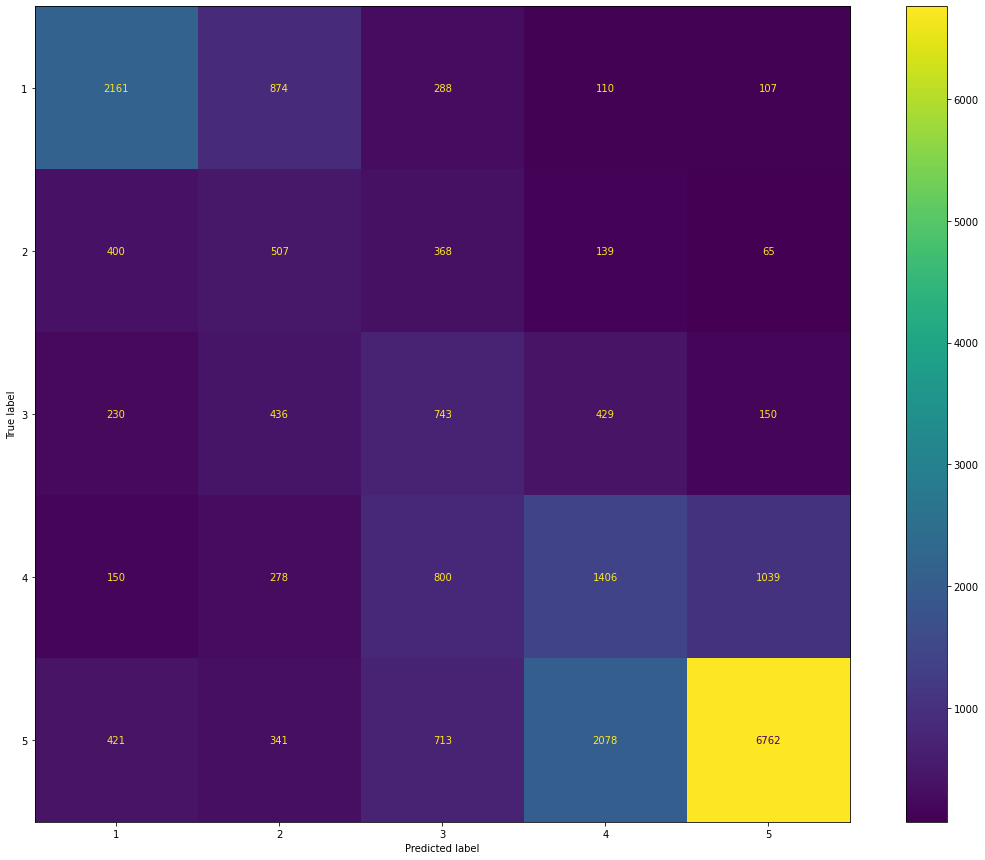

In [25]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, prediction))
print(f"AUC Score: {roc_auc_score(y_test, probs, multi_class='ovo')}")
cm = confusion_matrix(y_test, prediction, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()